In [18]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from scipy.stats import bernoulli
from scipy.stats import gaussian_kde
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import random
from scipy.stats import gaussian_kde, multivariate_normal
import time
import re
from sklearn.neighbors import KernelDensity
import itertools
import time
from concurrent.futures import ProcessPoolExecutor



## Scenario Generation

### Price data

In [3]:
# Day-ahead price
def process_da_file(file_path):
    df = pd.read_csv(file_path)
    data = df.iloc[3:27, 2].tolist()
    return data

# Real-time price
def process_rt_file(file_path):
    df = pd.read_csv(file_path)
    data = df.iloc[3:99, 2].values.reshape(-1, 4).mean(axis=1)
    return data.tolist()

directory_path_da = 'C:/Users/user/Desktop/모의 실시간시장 가격/하루전'
directory_path_rt = 'C:/Users/user/Desktop/모의 실시간시장 가격/실시간 확정'

csv_files_da = [f for f in os.listdir(directory_path_da) if f.endswith('.csv')]
csv_files_rt = [f for f in os.listdir(directory_path_rt) if f.endswith('.csv')]

data = []

for da_file, rt_file in zip(csv_files_da, csv_files_rt):
    match = re.search(r'(\d{8})', da_file)
    if match:
        date_str = match.group(1)
        date = datetime.strptime(date_str, '%Y%m%d')

        day_ahead_data = process_da_file(os.path.join(directory_path_da, da_file))
        real_time_data = process_rt_file(os.path.join(directory_path_rt, rt_file))

        for hour in range(24):
            timestamp = date + timedelta(hours=hour)
            data.append({'P(da)': day_ahead_data[hour], 'P(rt)': real_time_data[hour], 'timestamp': timestamp})

original_price_df = pd.DataFrame(data)

original_price_df


,P(da),P(rt),timestamp
0,107.39,139.0375,2024-03-01 00:00:00
1,95.30,95.3000,2024-03-01 01:00:00
2,87.89,87.8900,2024-03-01 02:00:00
3,0.00,86.5000,2024-03-01 03:00:00
4,0.00,88.7800,2024-03-01 04:00:00
...,...,...,...
6499,131.14,151.8300,2024-11-26 19:00:00
6500,117.78,117.7800,2024-11-26 20:00:00
6501,114.22,114.2200,2024-11-26 21:00:00
6502,104.85,104.8500,2024-11-26 22:00:00


### Power Generation data

In [4]:
E_1_df = pd.read_csv('C:/Users/user/Desktop/jeju_estim.csv')
E_1_df['timestamp'] = pd.to_datetime(E_1_df['timestamp'])
E_1_df['timestamp'] = E_1_df['timestamp'].dt.tz_localize(None)
E_1_df.rename(columns={'forecast_da': 'E_0', 'forecast_rt': 'E_1', 'timestamp': 'date'}, inplace=True)

E_1_df = (E_1_df.set_index('date').resample('H').sum().reset_index())

E_1_df

,date,gen,capacity,E_0,E_1
0,2024-01-01 00:00:00,0.0,54991.875,0.000000,0.00000
1,2024-01-01 01:00:00,0.0,73322.500,0.000000,0.00000
2,2024-01-01 02:00:00,0.0,73322.500,0.000000,0.00000
3,2024-01-01 03:00:00,0.0,73322.500,0.000000,0.00000
4,2024-01-01 04:00:00,0.0,73322.500,0.000000,0.00000
...,...,...,...,...,...
7892,2024-11-24 20:00:00,0.0,84088.400,23.083183,9.67236
7893,2024-11-24 21:00:00,0.0,84088.400,0.000000,0.00000
7894,2024-11-24 22:00:00,0.0,84088.400,0.000000,0.00000
7895,2024-11-24 23:00:00,0.0,84088.400,0.000000,0.00000


## 계속

In [5]:
# 시간대 6시 - 18시, 날짜 3월 ~ 현재

E_1_filtered = E_1_df.loc[(E_1_df['date'].dt.hour >= 6) & (E_1_df['date'].dt.hour <= 18)].copy()
P_da_filtered = original_price_df.loc[(original_price_df['timestamp'].dt.hour >= 6) & 
                                      (original_price_df['timestamp'].dt.hour <= 18) & 
                                      (original_price_df['timestamp'].dt.minute == 0)].copy()
P_rt_filtered = original_price_df.loc[(original_price_df['timestamp'].dt.hour >= 6) & 
                                      (original_price_df['timestamp'].dt.hour <= 18)].copy()

E_1_filtered['date'] = pd.to_datetime(E_1_filtered['date'])
E_1_filtered['hour'] = E_1_filtered['date'].dt.hour

P_da_filtered['date'] = pd.to_datetime(P_da_filtered['timestamp'])
P_da_filtered['hour'] = P_da_filtered['timestamp'].dt.hour

P_rt_filtered['date'] = pd.to_datetime(P_rt_filtered['timestamp'])
P_rt_filtered['hour'] = P_rt_filtered['timestamp'].dt.hour

start_date = '2024-03-01'
end_date = '2024-11-25'

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
E_1_filtered = E_1_filtered[(E_1_filtered['date'] >= start_date) & (E_1_filtered['date'] <= end_date)]
P_da_filtered = P_da_filtered[(P_da_filtered['date'] >= start_date) & (P_da_filtered['date'] <= end_date)]
P_rt_filtered = P_rt_filtered[(P_rt_filtered['date'] >= start_date) & (P_rt_filtered['date'] <= end_date)]

merged_df = pd.merge(E_1_filtered, P_da_filtered[['date', 'hour', 'P(da)']], on=['date', 'hour'], how='left')
merged_df = pd.merge(merged_df, P_rt_filtered[['date', 'hour', 'P(rt)']], on=['date', 'hour'], how='left')
merged_df.fillna(0, inplace=True)

merged_df['date'] = merged_df.apply(lambda row: row['date'].replace(hour=row['hour']), axis=1)
merged_df.drop(columns=['hour'], inplace=True)

merged_df


,date,gen,capacity,E_0,E_1,P(da),P(rt)
0,2024-03-01 06:00:00,0.000000,73855.62,0.000000,0.000000,111.40,111.40
1,2024-03-01 07:00:00,398.017060,73855.62,362.987065,430.405869,0.00,111.40
2,2024-03-01 08:00:00,3079.913940,73855.62,3277.902783,3116.289700,111.67,111.67
3,2024-03-01 09:00:00,7668.603330,73855.62,7402.975338,7808.194833,109.57,109.57
4,2024-03-01 10:00:00,11549.601870,73855.62,10897.530620,11396.836888,0.00,-33.47
...,...,...,...,...,...,...,...
3492,2024-11-24 14:00:00,8400.248230,84088.40,9494.636672,8749.996007,78.40,78.40
3493,2024-11-24 15:00:00,5286.825510,84088.40,6171.914289,5589.841665,87.55,87.55
3494,2024-11-24 16:00:00,1901.097000,84088.40,2353.333188,2009.100968,91.52,91.52
3495,2024-11-24 17:00:00,166.459667,84088.40,323.661456,184.873855,126.67,108.84


In [6]:
"""
# Plot histograms for P(da) and P(rt) in merged_df
columns_to_plot = ['P(da)', 'P(rt)']
colors = ['blue', 'orange']  # Assigning specific colors

plt.figure(figsize=(12, 6))

for i, (col, color) in enumerate(zip(columns_to_plot, colors)):
    plt.subplot(1, 2, i + 1)
    plt.hist(merged_df[col], bins=30, alpha=0.7, color=color, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()
"""


"\n# Plot histograms for P(da) and P(rt) in merged_df\ncolumns_to_plot = ['P(da)', 'P(rt)']\ncolors = ['blue', 'orange']  # Assigning specific colors\n\nplt.figure(figsize=(12, 6))\n\nfor i, (col, color) in enumerate(zip(columns_to_plot, colors)):\n    plt.subplot(1, 2, i + 1)\n    plt.hist(merged_df[col], bins=30, alpha=0.7, color=color, edgecolor='black')\n    plt.title(f'Distribution of {col}')\n    plt.xlabel(col)\n    plt.ylabel('Frequency')\n    plt.grid(True)\n\nplt.tight_layout()\nplt.show()\n"

In [7]:
"""
#상관관계 확인
correlation_matrix = merged_df[['P(da)', 'P(rt)', 'E_1']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()
"""

"\n#상관관계 확인\ncorrelation_matrix = merged_df[['P(da)', 'P(rt)', 'E_1']].corr()\nplt.figure(figsize=(8, 6))\nsns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True)\nplt.title('Correlation Heatmap', fontsize=16)\nplt.show()\n"

In [8]:
# P(da) < 0, P(rt) < 0, P(da) > P(rt) 필터링

filtered_df = merged_df[(merged_df['P(da)'] < 0) & 
                        (merged_df['P(rt)'] < 0) & 
                        (merged_df['P(da)'] > merged_df['P(rt)'])]

filtered_df.reset_index(drop=True, inplace=True)
filtered_df.index = filtered_df.index + 1

filtered_df

,date,gen,capacity,E_0,E_1,P(da),P(rt)
1,2024-03-20 10:00:00,11374.72210,73855.62,12921.671022,12098.547212,-19.00,-64.9500
2,2024-03-20 14:00:00,11545.70480,73855.62,13960.495545,12820.972934,-76.38,-77.9400
3,2024-03-22 11:00:00,12147.00420,73855.62,7620.238999,11350.978354,-19.00,-77.9400
4,2024-03-22 13:00:00,10268.35140,73855.62,8106.773944,10194.921603,-25.98,-73.6100
5,2024-04-27 13:00:00,14161.64050,73855.62,14702.496000,14482.890979,-2.00,-79.3200
6,2024-05-07 09:00:00,2662.33780,73855.62,4555.100600,2911.319311,-77.94,-79.0600
7,2024-05-09 09:00:00,10625.95000,73855.62,10666.601309,10697.097557,-77.94,-78.7800
8,2024-05-09 10:00:00,12872.36280,73855.62,12797.646767,13019.468280,-2.00,-78.7800
9,2024-05-10 10:00:00,12732.06040,73855.62,12871.581976,13076.894603,-2.00,-39.7925
10,2024-05-12 14:00:00,12018.73610,73855.62,10317.904728,11412.269470,-2.00,-79.0600


In [9]:
"""
# 산점도 그리기
plt.figure(figsize=(8, 6))
plt.scatter(E_0_values, E_1_values, alpha=0.7, c='blue', edgecolor='k')
plt.title("Scatter Plot of E_0 and E_1")
plt.xlabel("E_0")
plt.ylabel("E_1")
plt.grid(True)
plt.show()
"""

'\n# 산점도 그리기\nplt.figure(figsize=(8, 6))\nplt.scatter(E_0_values, E_1_values, alpha=0.7, c=\'blue\', edgecolor=\'k\')\nplt.title("Scatter Plot of E_0 and E_1")\nplt.xlabel("E_0")\nplt.ylabel("E_1")\nplt.grid(True)\nplt.show()\n'

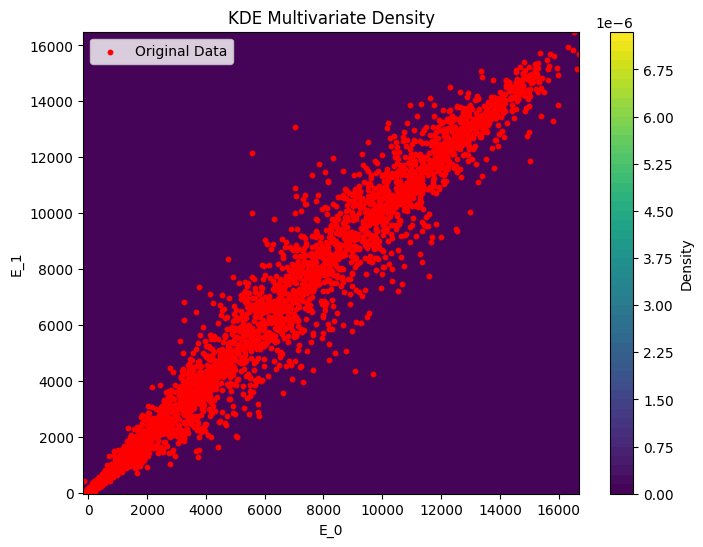

In [10]:
# E_0 기반 E_1 conditional KDE
E_0_values = merged_df['E_0'].values.reshape(-1, 1)
E_1_values = merged_df['E_1'].values

kde = KernelDensity(kernel='gaussian', bandwidth=10)
kde.fit(np.hstack([E_0_values, E_1_values.reshape(-1, 1)]))

E_0_range = np.linspace(E_0_values.min(), E_0_values.max(), 100)
E_1_range = np.linspace(E_1_values.min(), E_1_values.max(), 100)
E_0_grid, E_1_grid = np.meshgrid(E_0_range, E_1_range)
grid_points = np.vstack([E_0_grid.ravel(), E_1_grid.ravel()]).T

log_density = kde.score_samples(grid_points)
density = np.exp(log_density).reshape(E_0_grid.shape)

plt.figure(figsize=(8, 6))
plt.contourf(E_0_grid, E_1_grid, density, levels=50, cmap='viridis')
plt.colorbar(label="Density")
plt.scatter(E_0_values, E_1_values, c='red', s=10, label="Original Data")
plt.title("KDE Multivariate Density")
plt.xlabel("E_0")
plt.ylabel("E_1")
plt.legend()
plt.show()


In [11]:
"""
correlation_matrix = filtered_df[['P(da)', 'P(rt)', 'E_1']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()
"""

"\ncorrelation_matrix = filtered_df[['P(da)', 'P(rt)', 'E_1']].corr()\nplt.figure(figsize=(8, 6))\nsns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True)\nplt.title('Correlation Heatmap', fontsize=16)\nplt.show()\n"

In [12]:
#상관관계 고려한 샘플링. 사용 X

"""
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde, multivariate_normal

# 시나리오 생성 함수 정의
def generate_scenarios(seed, N, proposal_std=0.5):
    np.random.seed(seed)
    
    scenarios = []

    kde = gaussian_kde(merged_df[['E_1', 'P(da)', 'P(rt)']].T)
    cov_matrix = np.cov(merged_df[['E_0', 'E_1']].T)
    mean_E0 = merged_df['E_0'].mean()
    mean_E1 = merged_df['E_1'].mean()
    cov_E0E1 = cov_matrix[0, 1] / cov_matrix[0, 0]
    cond_mean_E1 = mean_E1 + cov_E0E1 * (E_0 - mean_E0)
    cond_var_E1 = cov_matrix[1, 1] - cov_E0E1 * cov_matrix[0, 1]

    current_E_1 = np.random.normal(cond_mean_E1, np.sqrt(cond_var_E1) + proposal_std) 
    current_P_da, current_P_rt = kde.resample(1).flatten()[1:]
    current_sample = np.array([current_E_1, current_P_da, current_P_rt])

    while len(scenarios) < N:
        proposed_P_da, proposed_P_rt = kde.resample(1).flatten()[1:]
        proposed_E_1 = np.random.normal(cond_mean_E1, np.sqrt(cond_var_E1) + proposal_std)
        proposed_sample = np.array([proposed_E_1, proposed_P_da, proposed_P_rt])
        
        # Metropolis-Hastings 알고리즘
        current_density = kde.pdf(current_sample) * multivariate_normal.pdf(current_sample[0], mean=cond_mean_E1, cov=cond_var_E1)
        proposed_density = kde.pdf(proposed_sample) * multivariate_normal.pdf(proposed_sample[0], mean=cond_mean_E1, cov=cond_var_E1)
        acceptance_ratio = min(1, proposed_density / current_density)

        if np.random.rand() < acceptance_ratio:
            current_sample = proposed_sample
            current_E_1, current_P_da, current_P_rt = proposed_E_1, proposed_P_da, proposed_P_rt

        if np.random.rand() < 0.05: 
            random_factor = np.random.uniform(0, 2)
        else: 
            random_factor = 1.0

        scenarios.append((current_P_da, current_P_rt, current_E_1, random_factor))

        scenarios_df = pd.DataFrame(scenarios, columns=['P_da', 'P_rt', 'E_1', 'random_factor'])
        scenarios_df.drop_duplicates(subset=['P_da', 'P_rt', 'E_1'], keep='first', inplace=True)
        scenarios = scenarios_df.values.tolist()

    return scenarios[:N]

E_0 = merged_df['E_0'].mean() 
scenarios = generate_scenarios(seed=42, N=100, proposal_std=0.5) 
scenarios_df = pd.DataFrame(scenarios, columns=['P_da', 'P_rt', 'E_1', 'random_factor'])

print(scenarios_df.head())
"""

"\nimport numpy as np\nimport pandas as pd\nfrom scipy.stats import gaussian_kde, multivariate_normal\n\n# 시나리오 생성 함수 정의\ndef generate_scenarios(seed, N, proposal_std=0.5):\n    np.random.seed(seed)\n    \n    scenarios = []\n\n    kde = gaussian_kde(merged_df[['E_1', 'P(da)', 'P(rt)']].T)\n    cov_matrix = np.cov(merged_df[['E_0', 'E_1']].T)\n    mean_E0 = merged_df['E_0'].mean()\n    mean_E1 = merged_df['E_1'].mean()\n    cov_E0E1 = cov_matrix[0, 1] / cov_matrix[0, 0]\n    cond_mean_E1 = mean_E1 + cov_E0E1 * (E_0 - mean_E0)\n    cond_var_E1 = cov_matrix[1, 1] - cov_E0E1 * cov_matrix[0, 1]\n\n    current_E_1 = np.random.normal(cond_mean_E1, np.sqrt(cond_var_E1) + proposal_std) \n    current_P_da, current_P_rt = kde.resample(1).flatten()[1:]\n    current_sample = np.array([current_E_1, current_P_da, current_P_rt])\n\n    while len(scenarios) < N:\n        proposed_P_da, proposed_P_rt = kde.resample(1).flatten()[1:]\n        proposed_E_1 = np.random.normal(cond_mean_E1, np.sqrt(cond_var

In [13]:
# 가격 시나리오 생성 함수
def generate_price_scenarios(filtered_df, N_price, seed=None):
    if seed:
        np.random.seed(seed)
    
    P_da_distribution = filtered_df['P(da)'].tolist()
    P_rt_distribution = filtered_df['P(rt)'].tolist()

    P_da_samples = np.random.choice(P_da_distribution, N_price)
    P_rt_samples = np.random.choice(P_rt_distribution, N_price)

    P_rt_final = []
    P_da_final = []

    for P_da, P_rt in zip(P_da_samples, P_rt_samples):
        if P_rt <= P_da:
            P_rt_final.append(P_rt)
            P_da_final.append(P_da)
        else:
            P_rt_final.append(P_da)
            P_da_final.append(P_da)

    return P_da_final, P_rt_final

"""
# 가격 figure 정리
N_price = 1000
seed = 42
P_da_samples, P_rt_samples = generate_price_scenarios(filtered_df, N_price, seed=seed)

sampled_prices = pd.DataFrame({
    'P(da)': P_da_samples,
    'P(rt)': P_rt_samples
})

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(P_da_samples, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title("Sampled P(da) Distribution")
plt.xlabel("P(da) (Day-Ahead Price)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(P_rt_samples, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title("Sampled P(rt) Distribution")
plt.xlabel("P(rt) (Real-Time Price)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()
"""

'\n# 가격 figure 정리\nN_price = 1000\nseed = 42\nP_da_samples, P_rt_samples = generate_price_scenarios(filtered_df, N_price, seed=seed)\n\nsampled_prices = pd.DataFrame({\n    \'P(da)\': P_da_samples,\n    \'P(rt)\': P_rt_samples\n})\n\nplt.figure(figsize=(10, 5))\n\nplt.subplot(1, 2, 1)\nplt.hist(P_da_samples, bins=30, alpha=0.7, color=\'blue\', edgecolor=\'black\')\nplt.title("Sampled P(da) Distribution")\nplt.xlabel("P(da) (Day-Ahead Price)")\nplt.ylabel("Frequency")\n\nplt.subplot(1, 2, 2)\nplt.hist(P_rt_samples, bins=30, alpha=0.7, color=\'green\', edgecolor=\'black\')\nplt.title("Sampled P(rt) Distribution")\nplt.xlabel("P(rt) (Real-Time Price)")\nplt.ylabel("Frequency")\n\nplt.tight_layout()\nplt.show()\n'

In [14]:
# 발전량 시나리오 생성 함수
def generate_E_1_scenarios(N_E1, kde, E_0):
    E_0_min, E_0_max = E_0_values.min(), E_0_values.max()
    E_0_range = E_0_max - E_0_min 

    correlation = np.corrcoef(E_0_values.ravel(), E_1_values.ravel())[0, 1]
    alpha = 0.1 * E_0_range 
    tolerance = alpha * (1 - abs(correlation))
    
    mask = (E_0_values.ravel() >= E_0 - tolerance) & (E_0_values.ravel() <= E_0 + tolerance)
    E_1_subset = E_1_values[mask].reshape(-1, 1)
    
    kde_conditional = KernelDensity(kernel='gaussian', bandwidth=5)
    kde_conditional.fit(E_1_subset)
    
    E_1_scenarios = kde_conditional.sample(N_E1).ravel()
    return E_1_scenarios


In [15]:
# 급전지시량 시나리오 생성 함수
def generate_random_factor_scenarios(N_Qc=10, mean=1.0, std_dev=0.2):

    num_ones = int(0.9 * N_Qc)
    ones = [1.0] * num_ones

    num_rest = N_Qc - num_ones
    discrete_values = [0.2 + 0.2 * i for i in range(10)] 
    if num_rest > 0:
        weights = np.exp(-((np.array(discrete_values) - mean) ** 2) / (2 * std_dev ** 2))
        weights /= weights.sum()
        rest = np.random.choice(discrete_values, size=num_rest, p=weights, replace=True)
    else:
        rest = []

    scenarios = ones + rest.tolist()
    np.random.shuffle(scenarios) 
    return scenarios

"""
# 급전지시량 figure 정리
random_factors = generate_random_factor_scenarios(N_Qc=1000)  

discrete_values = [0.2 + 0.2 * i for i in range(10)] 
counts = [random_factors.count(val) for val in discrete_values]
probabilities = [count / len(random_factors) for count in counts] 

plt.figure(figsize=(12, 6))
plt.bar(discrete_values, probabilities, width=0.1, color="skyblue", edgecolor="black", align='center')

plt.title("Random factor Scenarios Distribution", fontsize=16)
plt.xlabel("Random factor", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.xticks(discrete_values, [f"{val:.1f}" for val in discrete_values], fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
"""

'\n# 급전지시량 figure 정리\nrandom_factors = generate_random_factor_scenarios(N_Qc=1000)  \n\ndiscrete_values = [0.2 + 0.2 * i for i in range(10)] \ncounts = [random_factors.count(val) for val in discrete_values]\nprobabilities = [count / len(random_factors) for count in counts] \n\nplt.figure(figsize=(12, 6))\nplt.bar(discrete_values, probabilities, width=0.1, color="skyblue", edgecolor="black", align=\'center\')\n\nplt.title("Random factor Scenarios Distribution", fontsize=16)\nplt.xlabel("Random factor", fontsize=14)\nplt.ylabel("Probability", fontsize=14)\nplt.xticks(discrete_values, [f"{val:.1f}" for val in discrete_values], fontsize=12, rotation=45)\nplt.yticks(fontsize=12)\nplt.grid(axis=\'y\', linestyle=\'--\', alpha=0.7)\n\nplt.tight_layout()\nplt.show()\n'

In [17]:
# 시나리오 생성 함수

def generate_scenarios_with_streaming(filtered_df, N_E1, N_price, kde, E_0, sample_size=10000):
    """
    스트리밍 방식으로 시나리오를 생성.

    Args:
        N_E1: E_1 시나리오의 개수
        N_price: 가격 시나리오의 개수
        kde: KDE 객체
        E_0: 고정된 E_0 값
        sample_size: 샘플링할 시나리오 개수

    Returns:
        샘플링된 시나리오 리스트 [(P_da, P_rt, E_1, random_factor), ...]
    """

    P_da_samples, P_rt_samples = generate_price_scenarios(filtered_df, N_price)

    E_1_scenarios = generate_E_1_scenarios(N_E1, kde, E_0)
    
    random_factors = generate_random_factor_scenarios()

    all_scenarios = itertools.product(P_da_samples, P_rt_samples, E_1_scenarios, random_factors)

    # 샘플링
    reservoir = []
    for idx, scenario in enumerate(all_scenarios):
        if len(reservoir) < sample_size:
            reservoir.append(scenario)
        else:
            replace_idx = random.randint(0, idx)
            if replace_idx < sample_size:
                reservoir[replace_idx] = scenario

    return reservoir

start_time = time.time()

# 전체 시나리오 생성
seed = 42
random.seed(seed)
N_E1 = 200
N_price = 200
total_sample_size = 400000  # 전체 시나리오 개수

E_0 = 10000  # E_0 값

all_scenarios = generate_scenarios_with_streaming(filtered_df, N_E1, N_price, kde, E_0, sample_size=total_sample_size)

# 샘플링 (MC Simulation용)
num_mc_scenarios = 10000
mc_scenarios = random.sample(all_scenarios, num_mc_scenarios)

end_time = time.time()
execution_time = end_time - start_time

# 실행 시간 출력
print(f"Total Execution Time: {execution_time:.2f} seconds")
print()


print("Sampled MC Scenarios (Top 10):")
for i, scenario in enumerate(mc_scenarios[:10], 1):
    print(f"MC Scenario {i}:  P_da = {scenario[0]:.2f}, P_rt = {scenario[1]:.2f}, E_1 = {scenario[2]:.2f}, Random Factor = {scenario[3]:.2f}")


Total Execution Time: 59.47 seconds

Sampled MC Scenarios (Top 10):
MC Scenario 1:  P_da = -2.00, P_rt = -79.06, E_1 = 10882.35, Random Factor = 1.00
MC Scenario 2:  P_da = -77.48, P_rt = -79.06, E_1 = 11370.54, Random Factor = 1.00
MC Scenario 3:  P_da = -2.00, P_rt = -77.94, E_1 = 10885.27, Random Factor = 1.00
MC Scenario 4:  P_da = -48.00, P_rt = -39.79, E_1 = 10880.86, Random Factor = 1.00
MC Scenario 5:  P_da = -0.19, P_rt = -79.32, E_1 = 10515.69, Random Factor = 1.00
MC Scenario 6:  P_da = -0.71, P_rt = -77.94, E_1 = 10882.23, Random Factor = 1.00
MC Scenario 7:  P_da = -51.27, P_rt = -79.06, E_1 = 9929.50, Random Factor = 1.00
MC Scenario 8:  P_da = -77.94, P_rt = -77.94, E_1 = 8710.27, Random Factor = 1.00
MC Scenario 9:  P_da = -17.57, P_rt = -77.48, E_1 = 10923.41, Random Factor = 1.00
MC Scenario 10:  P_da = -71.15, P_rt = -79.06, E_1 = 10861.46, Random Factor = 1.00


In [ ]:
# 샘플링 (Stochastic Programming 용)
num_so_scenarios = 10
so_scenarios = random.sample(all_scenarios, num_so_scenarios)

print("Sampled SO Scenarios (Top 10):")
for i, scenario in enumerate(so_scenarios[:10], 1):
    print(f"SO Scenario {i}: P_da = {scenario[0]:.2f}, P_rt = {scenario[1]:.2f}, E_1 = {scenario[2]:.2f}, Random Factor = {scenario[3]:.2f}")

In [17]:
# 그 외 초기 상수
P_r = 80
C = 18330.6
M = 10**6

In [25]:
# 최적화 모델 생성
def build_model(scenarios):
    model = pyo.ConcreteModel()

    # Parameters
    model.E_0 = pyo.Param(initialize=E_0, mutable=True)

    num_scenarios = len(scenarios)

    # First-stage decision variables
    model.b_da = pyo.Var(bounds=(-P_r, 0), domain=pyo.Reals, initialize = -P_r / 2)
    model.q_da = pyo.Var(domain=pyo.Reals, bounds=(0.9*E_0, 1.1*E_0), initialize = E_0)

    # Scenario-specific components
    model.scenarios = pyo.RangeSet(0, num_scenarios - 1)
    model.P_da = pyo.Param(model.scenarios, initialize={i: scenarios[i][0] for i in range(num_scenarios)})
    model.P_rt = pyo.Param(model.scenarios, initialize={i: scenarios[i][1] for i in range(num_scenarios)})
    model.E_1 = pyo.Param(model.scenarios, initialize={i: scenarios[i][2] for i in range(num_scenarios)})
    model.random_factor = pyo.Param(model.scenarios, initialize={i: scenarios[i][3] for i in range(num_scenarios)})

    # Second-stage decision variables
    def q_rt_bounds(model, s):
        return model.E_1[s]
    model.b_rt = pyo.Var(model.scenarios, bounds=(-P_r, 0), domain=pyo.Reals, initialize = - P_r / 2)
    model.q_rt = pyo.Var(model.scenarios, bounds=q_rt_bounds, domain=pyo.Reals, initialize=lambda model, s: model.E_1[s])

    # Scenario-specific binary variables
    model.y_da = pyo.Var(model.scenarios, domain=pyo.Binary)
    model.y_rt = pyo.Var(model.scenarios, domain=pyo.Binary)

    # Scenario-specific analysis variables
    model.Q_da = pyo.Var(model.scenarios, domain=pyo.NonNegativeReals, initialize= model.q_da / 2)
    model.Q_rt = pyo.Var(model.scenarios, domain=pyo.NonNegativeReals, initialize=lambda model, s: model.q_rt[s] / 2)
    model.Q_c = pyo.Var(model.scenarios, domain=pyo.NonNegativeReals, initialize=lambda model, s: model.random_factor[s])

    # Third-stage decision variables
    def z_bounds(model, s):
        return (0, model.E_1[s])
    model.z = pyo.Var(model.scenarios, bounds=z_bounds, domain=pyo.Reals, initialize=lambda model, s: model.E_1[s])

    # Linearization Real Variables
    model.m1_V = pyo.Var(model.scenarios, domain=pyo.Reals)
    model.m2_V = pyo.Var(model.scenarios, domain=pyo.Reals)
    model.m1_E = pyo.Var(model.scenarios, domain=pyo.Reals)
    model.m2_E = pyo.Var(model.scenarios, domain=pyo.Reals)
    model.m3_E = pyo.Var(model.scenarios, domain=pyo.Reals)
    model.m1_Im = pyo.Var(model.scenarios, domain=pyo.Reals)
    model.m2_Im = pyo.Var(model.scenarios, domain=pyo.Reals)
    model.m3_Im = pyo.Var(model.scenarios, domain=pyo.Reals)
    model.m4_Im = pyo.Var(model.scenarios, domain=pyo.Reals)
    model.S1_V = pyo.Var(model.scenarios, domain=pyo.Reals)
    model.S1_E = pyo.Var(model.scenarios, domain=pyo.Reals)
    model.S1_Im = pyo.Var(model.scenarios, domain=pyo.Reals)
    model.S2_Im = pyo.Var(model.scenarios, domain=pyo.Reals)
    model.f_E = pyo.Var(model.scenarios, domain=pyo.Reals)
    model.f_max = pyo.Var(model.scenarios, domain=pyo.Reals)

    # Linearization Binary Variables (Scenario-specific)
    model.n1_V = pyo.Var(model.scenarios, domain=pyo.Binary)
    model.n2_V = pyo.Var(model.scenarios, domain=pyo.Binary)
    model.n1_E = pyo.Var(model.scenarios, domain=pyo.Binary)
    model.n2_E = pyo.Var(model.scenarios, domain=pyo.Binary)
    model.n3_E = pyo.Var(model.scenarios, domain=pyo.Binary)
    model.n1_Im = pyo.Var(model.scenarios, domain=pyo.Binary)
    model.n2_Im = pyo.Var(model.scenarios, domain=pyo.Binary)
    model.n3_Im = pyo.Var(model.scenarios, domain=pyo.Binary)
    model.n4_Im = pyo.Var(model.scenarios, domain=pyo.Binary)
    model.n1_F = pyo.Var(model.scenarios, domain=pyo.Binary)
    model.n2_F = pyo.Var(model.scenarios, domain=pyo.Binary)
    model.n3_F = pyo.Var(model.scenarios, domain=pyo.Binary)

    # Constraints
    model.constrs = pyo.ConstraintList()
    def scenario_constraints(model, s):

        model.constrs.add(model.b_da - model.P_da[s] <= M * (1 - model.y_da[s]))
        model.constrs.add(model.q_da <= M * model.y_da[s])
        model.constrs.add(model.Q_da[s] <= model.q_da)
        model.constrs.add(model.q_da - M * (1 - model.y_da[s]) <= model.Q_da[s])

        model.constrs.add(model.b_rt[s] - model.P_rt[s] <= M * (1 - model.y_rt[s]))
        model.constrs.add(model.q_rt[s] <= M * model.y_rt[s])
        model.constrs.add(model.q_rt[s] - M * (1 - model.y_rt[s]) <= model.Q_rt[s])
        model.constrs.add(model.Q_rt[s] <= model.q_rt[s])
 
        # Rule constraint
        model.constrs.add(model.Q_c[s] == model.random_factor[s] * model.Q_rt[s])
        model.constrs.add(model.b_rt[s] <= model.b_da)

        # f_V Linearization constraints
        model.constrs.add(model.S1_V[s] == model.b_rt[s] * model.m1_V[s] - model.Q_da[s] * model.P_da[s] - model.m1_V[s] * model.P_rt[s] + model.P_rt[s] * model.Q_da[s])
    
        model.constrs.add(model.m1_V[s] <= model.z[s])
        model.constrs.add(model.m1_V[s] <= model.Q_c[s])
        model.constrs.add(model.m1_V[s] >= model.z[s] - M * (1 - model.n1_V[s]))
        model.constrs.add(model.m1_V[s] >= model.Q_c[s] - M * model.n1_V[s])

        model.constrs.add(model.m2_V[s] >= model.S1_V[s])
        model.constrs.add(model.m2_V[s] >= 0)
        model.constrs.add(model.m2_V[s] <= model.S1_V[s] + M * (1 - model.n2_V[s]))
        model.constrs.add(model.m2_V[s] <= M * model.n2_V[s])

        # f_E Linearization constraints
        model.constrs.add(model.m1_E[s] <= model.Q_da[s])
        model.constrs.add(model.m1_E[s] <= model.q_rt[s])
        model.constrs.add(model.m1_E[s] >= model.Q_da[s] - M * (1 - model.n1_E[s]))
        model.constrs.add(model.m1_E[s] >= model.q_rt[s] - M * model.n1_E[s])
  
        model.constrs.add(model.m2_E[s] <= model.z[s])
        model.constrs.add(model.m2_E[s] <= model.q_rt[s])
        model.constrs.add(model.m2_E[s] >= model.z[s] - M * (1 - model.n2_E[s]))
        model.constrs.add(model.m2_E[s] >= model.q_rt[s] - M * model.n2_E[s])
  
        model.constrs.add(model.f_E[s] >= (model.P_rt[s] - model.b_da) * model.m1_E[s] - M * (1 - model.n3_E[s]))
        model.constrs.add(model.f_E[s] <= (model.P_rt[s] - model.b_da) * model.m2_E[s] + M * model.n3_E[s])

        model.constrs.add(model.f_E[s] == (model.P_rt[s] - model.b_da) * (model.m1_E[s] - model.m2_E[s]))
        
        # f_Im Linearization constraints
        model.constrs.add(model.S1_Im[s] == (model.z[s] - model.Q_c[s]) - 0.12 * C)

        model.constrs.add(model.S2_Im[s] == model.P_rt[s] - model.b_rt[s])

        model.constrs.add(model.m1_Im[s] >= model.S1_Im[s])
        model.constrs.add(model.m1_Im[s] >= 0)
        model.constrs.add(model.m1_Im[s] <= model.S1_Im[s] + M * (1 - model.n1_Im[s]))
        model.constrs.add(model.m1_Im[s] <= M * model.n1_Im[s])

        model.constrs.add(model.m2_Im[s] >= model.S2_Im[s])
        model.constrs.add(model.m2_Im[s] >= 0)
        model.constrs.add(model.m2_Im[s] <= model.S2_Im[s] + M * (1 - model.n2_Im[s]))
        model.constrs.add(model.m2_Im[s] <= M * model.n2_Im[s])
        model.constrs.add(model.m3_Im[s] >= -model.b_rt[s])
        model.constrs.add(model.m3_Im[s] >= 0)
        model.constrs.add(model.m3_Im[s] <= -model.b_rt[s] + M * (1 - model.n3_Im[s]))
        model.constrs.add(model.m3_Im[s] <= M * model.n3_Im[s])
        model.constrs.add(model.m4_Im[s] >= model.m3_Im[s])
        model.constrs.add(model.m4_Im[s] >= model.m2_Im[s])
        model.constrs.add(model.m4_Im[s] <= model.m3_Im[s] + M * (1 - model.n4_Im[s]))
        model.constrs.add(model.m4_Im[s] <= model.m2_Im[s] + M * model.n4_Im[s])

        # f_max linearization constraints
        model.constrs.add(model.f_max[s] >= model.m2_V[s])
        model.constrs.add(model.f_max[s] >= model.f_E[s])
        model.constrs.add(model.f_max[s] >= 0)
        model.constrs.add(model.f_max[s] <= model.m2_V[s] + M * (1 - model.n1_F[s]))
        model.constrs.add(model.f_max[s] <= model.f_E[s] + M * (1 - model.n2_F[s]))
        model.constrs.add(model.f_max[s] <= M * (1 - model.n3_F[s]))
        model.constrs.add(model.n1_F[s] + model.n2_F[s] + model.n3_F[s] == 1)
        
    for s in model.scenarios:
        scenario_constraints(model, s)

    # Non-anticipativity constraints
    for i in range(num_scenarios):
        for j in range(i + 1, num_scenarios):
            if scenarios[i][0] == scenarios[j][0] and scenarios[i][2] == scenarios[j][2]:
                model.constrs.add(model.b_rt[i] == model.b_rt[j])
                model.constrs.add(model.q_rt[i] == model.q_rt[j])  

    # Objective Function
    def objective_rule(model):
        return sum((model.P_da[s] * model.Q_da[s] + model.P_rt[s] * (model.z[s] - model.Q_da[s])) + model.f_max[s] + (-model.m1_Im[s] * model.m4_Im[s]) + (model.z[s] * P_r) for s in model.scenarios)

    model.objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)

    return model


def solve_model(scenarios):
    """SP 모델 풀이"""
    model = build_model(scenarios)
    solver = pyo.SolverFactory('gurobi')
    solver.options['NonConvex'] = 2
    start_time = time.time()

    result = solver.solve(model, tee=True)

    end_time = time.time()
    print(f"SP Model Solver Wall Time: {end_time - start_time:.2f} seconds\n")

    return model, result


def solve_perfect_forecasting_model(scenarios):
    """
    Perfect Forecasting 모델 풀이
    Perfect Forecasting은 모든 불확실성이 제거된 상태에서 확실한 미래 값(실제값)을 사용
    """
    # Perfect Forecasting 시나리오 생성: 모든 변수 값을 확정된 미래 값으로 설정
    perfect_scenarios = [
        [s[0], s[1], s[2], s[3]] for s in scenarios  # 모든 변수에 실제값(확정된 값) 사용
    ]

    # Perfect Forecasting 모델 생성 및 풀이
    model = build_model(perfect_scenarios)
    solver = pyo.SolverFactory('gurobi')
    solver.options['NonConvex'] = 2
    start_time = time.time()

    result = solver.solve(model, tee=True)

    end_time = time.time()
    print(f"Perfect Forecasting Solver Wall Time: {end_time - start_time:.2f} seconds\n")

    return model, result



def solve_eev_model(scenarios):
    """EEV (Expected Value Problem) 모델 풀이"""
    # EEV 시나리오: 모든 시나리오의 평균값을 사용
    eev_scenario = [
        sum(s[i] for s in scenarios) / len(scenarios) for i in range(len(scenarios[0]))
    ]  # 평균값 계산

    # EEV는 단일 시나리오만 사용
    eev_scenarios = [eev_scenario]

    # EEV 모델 생성 및 풀이
    model = build_model(eev_scenarios)
    solver = pyo.SolverFactory('gurobi')
    solver.options['NonConvex'] = 2
    start_time = time.time()

    result = solver.solve(model, tee=True)

    end_time = time.time()
    print(f"EEV Model Solver Wall Time: {end_time - start_time:.2f} seconds\n")

    return model, result



def evaluate_performance(sp_scenarios, user_defined_performance):
    """
    SP 모델 성능을 평가하고, WS (Perfect Forecasting), EEV (Expected Value Problem)과 비교
    :param sp_scenarios: SP 모델에서 사용할 시나리오 (예측값 기반)
    :param user_defined_performance: 사용자 정의 성능 지표 함수 (각 날에 대해 적용)
    """
    # SP 모델 풀이
    sp_model, _ = solve_model(sp_scenarios)

    # WS (Perfect Forecasting) 시나리오 풀이: 실제값 사용
    perfect_scenarios = [
        [s[0], s[1], s[2], 1.0] for s in sp_scenarios  # random_factor를 실제값으로 고정
    ]
    perfect_model, _ = solve_perfect_forecasting_model(perfect_scenarios)

    # EEV (Expected Value Problem) 시나리오 풀이: 예측값만 사용
    eev_model, _ = solve_model(sp_scenarios)  # EEV는 SP 시나리오에서 불확실성 고려 없이 풀이

    # 각 시나리오의 수익 계산
    results = []
    total_days = len(sp_scenarios)

    for s in range(total_days):
        # SP 수익
        sp_profit = pyo.value(sp_model.P_da[s]) * pyo.value(sp_model.Q_da[s]) + \
                    pyo.value(sp_model.P_rt[s]) * (pyo.value(sp_model.z[s]) - pyo.value(sp_model.Q_da[s]))

        # WS (Perfect Forecasting) 수익
        ws_profit = pyo.value(perfect_model.P_da[s]) * pyo.value(perfect_model.Q_da[s]) + \
                    pyo.value(perfect_model.P_rt[s]) * (pyo.value(perfect_model.z[s]) - pyo.value(perfect_model.Q_da[s]))

        # EEV 수익
        eev_profit = pyo.value(eev_model.P_da[s]) * pyo.value(eev_model.Q_da[s]) + \
                     pyo.value(eev_model.P_rt[s]) * (pyo.value(eev_model.z[s]) - pyo.value(eev_model.Q_da[s]))

        # 사용자 정의 성능 평가 (1=성공, 0=실패)
        performance = user_defined_performance(ws_profit, eev_profit, sp_profit)

        results.append({
            "날짜": f"Day {s + 1}",
            "WS 수익": ws_profit,
            "EEV 수익": eev_profit,
            "SP 수익": sp_profit,
            "Performance Measure": performance
        })

    # 결과를 DataFrame으로 변환
    df_results = pd.DataFrame(results)

    # 총합 계산
    df_results.loc["Total"] = df_results[["WS 수익", "EEV 수익", "SP 수익", "Performance Measure"]].sum()
    df_results.at["Total", "날짜"] = "Total"

    # 결과 출력
    print(df_results)

    return df_results


# 사용자 정의 성능 지표 예시 함수
def user_defined_performance(ws_profit, eev_profit, sp_profit):
    """
    사용자가 정의한 성능 지표를 반환 (1=성공, 0=실패)
    예: SP 수익이 WS 수익과 동일하면 성공으로 간주
    """
    # WS와 동일한 수익을 얻었다면 성공으로 간주
    return 1 if sp_profit >= ws_profit else 0


if __name__ == "__main__":
    # SP 모델 시나리오 (예측값 기반)
    sp_scenarios = so_scenarios  # 사용자 데이터로 대체

    # 성능 평가
    performance_results = evaluate_performance(sp_scenarios, user_defined_performance)




Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-06
Read LP format model from file C:\Users\user\AppData\Local\Temp\tmpom9beg0d.pyomo.lp
Reading time = 0.01 seconds
x1: 510 rows, 332 columns, 1150 nonzeros
Set parameter NonConvex to value 2
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 7600 6-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 510 rows, 332 columns and 1150 nonzeros
Model fingerprint: 0xfe2f4c7a
Model has 10 quadratic objective terms
Model has 40 quadratic constraints
Variable types: 192 continuous, 140 integer (140 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+06]
  Objective range  [9e-01, 8e+01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e